## Урок 6. Градиентный бустинг

### 1.Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [176]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

#plt.style.use('seaborn-tick')
#plt.rcParams.update({'font.size':14})

Используем один из "игрушечных" датасетов из той же библиотеки.

In [177]:
from sklearn.datasets import load_diabetes

In [178]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [179]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [180]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [181]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [182]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [183]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=5)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [185]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_mse = mean_squared_error(y_train, train_prediction)
    
    #print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    #с шагом {eta} на тренировочной выборке: {train_mse}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_mse = mean_squared_error(y_test, test_prediction)

    #print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    #с шагом {eta} на тестовой выборке: {test_mse}')
    
    return train_mse, test_mse

In [193]:
def get_error_plot(n_trees, train_err, test_err, labels):
    plt.figure(figsize=(20,20)) #(12,5))
    
    plt.subplot(121)
    plt.title('Train')
    plt.xlabel('Количество деревьев')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    for i in range(len(labels)):
        plt.plot(list(range(n_trees)), train_err[i], label=labels[i])
        #plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    
    plt.subplot(122)
    plt.title('Test')
    plt.xlabel('Количество деревьев')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    for i in range(len(labels)):
        plt.plot(list(range(n_trees)), test_err[i], label=labels[i])
    plt.legend(loc='best')
    
    plt.show()

#### Графики зависимости ошибки от числа  и глубины деревьев на обучающей и тестовой выборках 

In [194]:
n_trees = np.array(range(1, 42)) #(1, 26))
#n_trees = [1, 2, 4, 8, 12, 16] #(1, 26))
#max_depth = np.array(range(1, 14, 3)) #range(1, 14, 3))
max_depth = np.array([1, 2, 3, 7, 10, 15]) #range(1, 14, 3))
eta = 0.1 #0.1

#### Внимание, следующая ячейка считается очень долго. Каюсь, моя вина. Захотелось минимизировать код. 

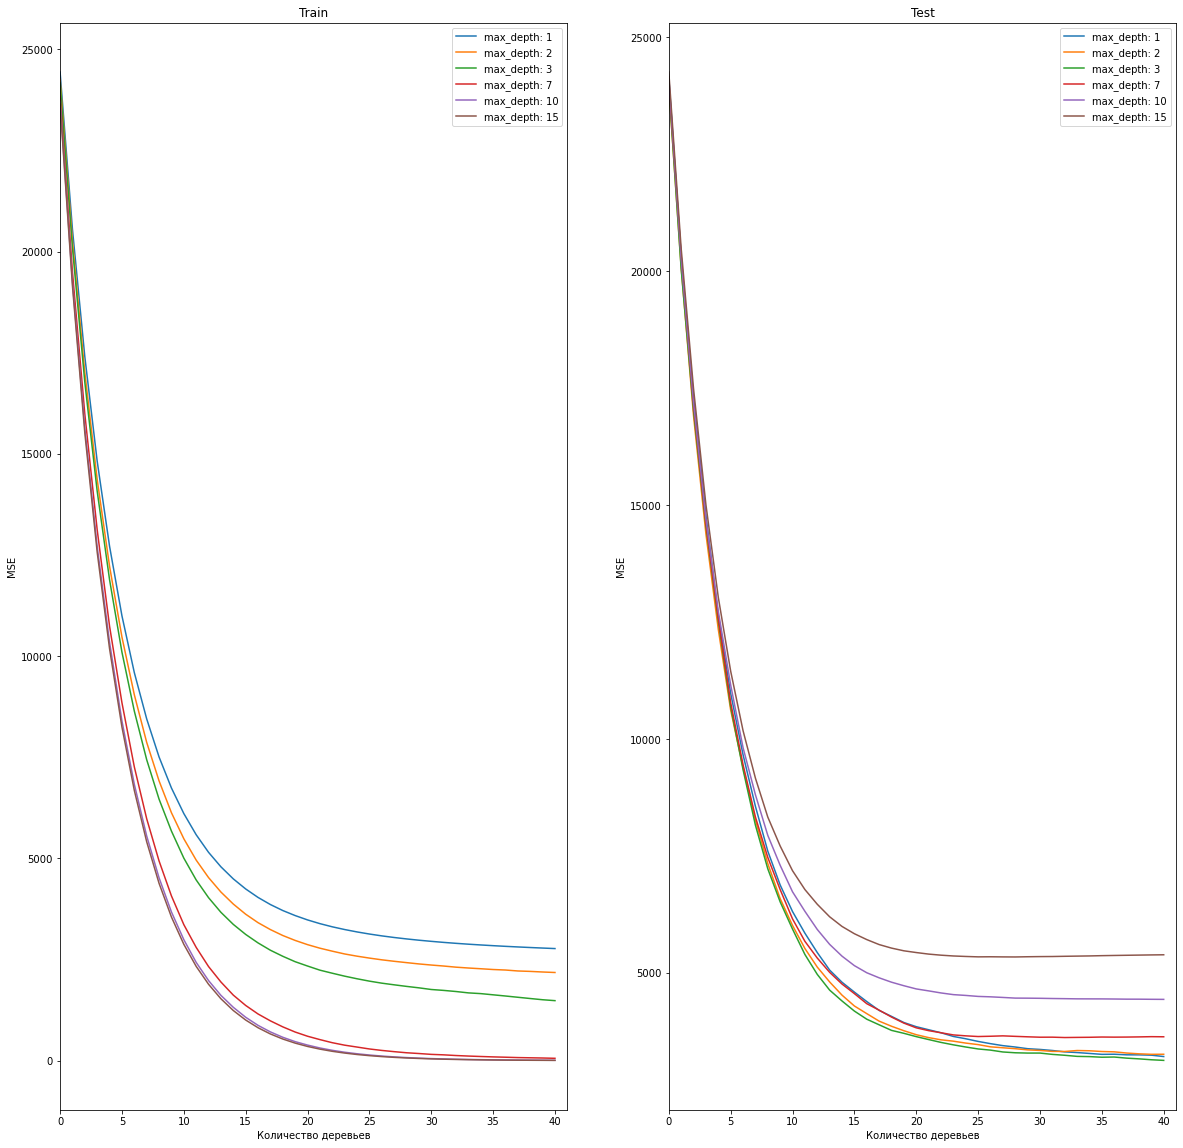

In [195]:
errs_train = []
errs_test = []
labels = []

for depth in max_depth:
    labels.append(f'max_depth: {depth}')
    ers_train = []
    ers_test = []
    for n in n_trees:
        coefs = [1] * n
        trees, train_errors, test_errors = gb_fit(n, depth, X_train, X_test, y_train, y_test, coefs, eta)
        er_train, er_test = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
        ers_train.append(er_train)
        ers_test.append(er_test)
    errs_train.append(ers_train)
    errs_test.append(ers_test)
    
get_error_plot(n, errs_train, errs_test, labels)

Наилучших показателей для этой модели (по MSE), она достигает при малой глубине деревьев (от 1 до 3). Стабилизация MSE на тесте, наступает про количестве деревьев > 30. При этих значениях, MSE на трейне и тесте (на глубине от 1 до 3), имеют минимальное расхождение.  